In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import nilearn

from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

/Users/home/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
os.getcwd()

'/Users/home/Documents/GitHub/MVPA-speech_project/MVPA-project-admin'

In [3]:
# Set variables
root_data='/Users/home/Documents/BIDS/'
sub='sub-0001'
ses='ses-001'
file_sep="/"

# data folder
data_path=root_data+file_sep+sub+file_sep+ses
print('The data is in this folder - '+data_path)

# project folder
root_project="/Users/home/Documents/GitHub/MVPA-speech_project"

The data is in this folder - /Users/home/Documents/BIDS//sub-0001/ses-001


# Structural data.

## Check registration using FSL BET (brain extraction) + FEAT

/Users/home/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


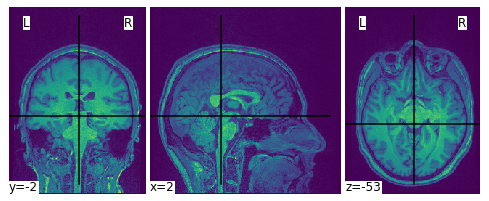

In [4]:
t1w_file_path=data_path+'/anat/sub-0001_ses-001_run-01_T1w.nii.gz'
plotting.plot_img(t1w_file_path)

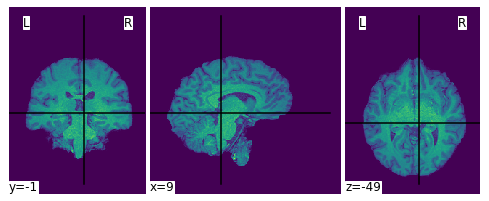

In [5]:
t1w_brain_file_path='/Users/home/Documents/BIDS/sub-0001/ses-001/anat/sub-0001_ses-001_run-01_T1w_brain.nii.gz'

plotting.plot_img(t1w_brain_file_path)

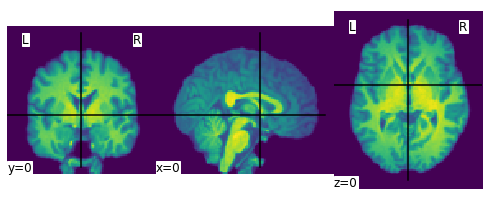

In [6]:
t1w_prepro_file_path='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/highres2standard.nii.gz'

cut_coords=(0, 0, 0)
plotting.plot_img(t1w_prepro_file_path, cut_coords)

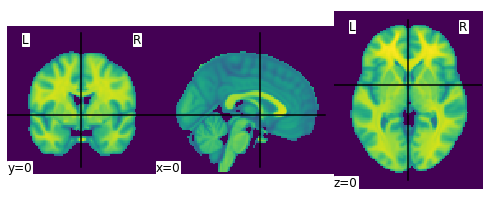

In [7]:
# (0,0,0) no standard MNI (mas tb em Talairach) aponta sempre para uma estrutura anatómica chamada de comissura anterior.
plotting.plot_img(datasets.MNI152_FILE_PATH, cut_coords)

# Functional data.
## Check preprocessing using FSL FEAT

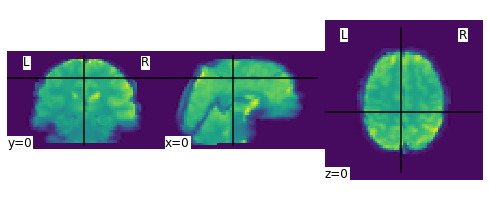

In [8]:
func_data_preproc='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data.nii.gz'

mean_fmri_img=mean_img(func_data_preproc)
plotting.plot_img(mean_fmri_img, cut_coords)

(91, 109, 91)


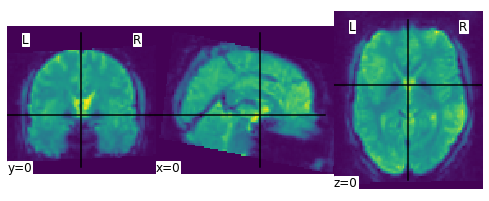

In [9]:
func_data_preproc_2high='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/example_func2standard.nii.gz'

mean_fmri_img_2high=mean_img(func_data_preproc_2high)

print(image.load_img(func_data_preproc_2high).shape)

plotting.plot_img(mean_fmri_img_2high, cut_coords)

(91, 109, 91, 222)


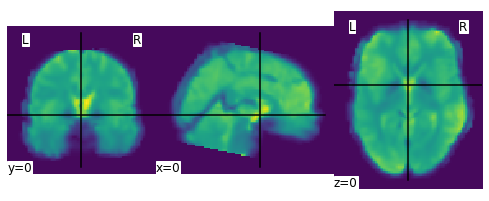

In [10]:
func_data_preproc2standard='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data2standard.nii.gz'
print(image.load_img(func_data_preproc2standard).shape)

mean_fmri_img_2standard=mean_img(func_data_preproc2standard)
plotting.plot_img(mean_fmri_img_2standard, cut_coords)

## Look at the events and design matrix.

In [11]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2.5  # repetition time is ? second
n_scans = 222  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH='/Users/home/Documents/GitHub/MVPA-speech_project/convert-bids-admin/DOCKER/events.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head())

print(frame_times[:5])


  trial_type  onset  duration
0  Baseline     0.0      12.5
1      Task    15.0      27.5
2  Baseline    45.0      12.5
3      Task    60.0      27.5
4  Baseline    90.0      12.5
[ 0.   2.5  5.   7.5 10. ]


In [12]:
# load events.tsv
events_PATH='/Users/home/Documents/GitHub/MVPA-speech_project/convert-bids-admin/DOCKER/betaseries_fonologico.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head(10))



   trial_type  onset  duration
0           0    0.0       2.5
1           1    2.5       2.5
2           2    5.0       2.5
3           3    7.5       2.5
4           4   10.0       2.5
5           5   12.5       2.5
6           6   15.0       2.5
7           7   17.5       2.5
8           8   20.0       2.5
9           9   22.5       2.5


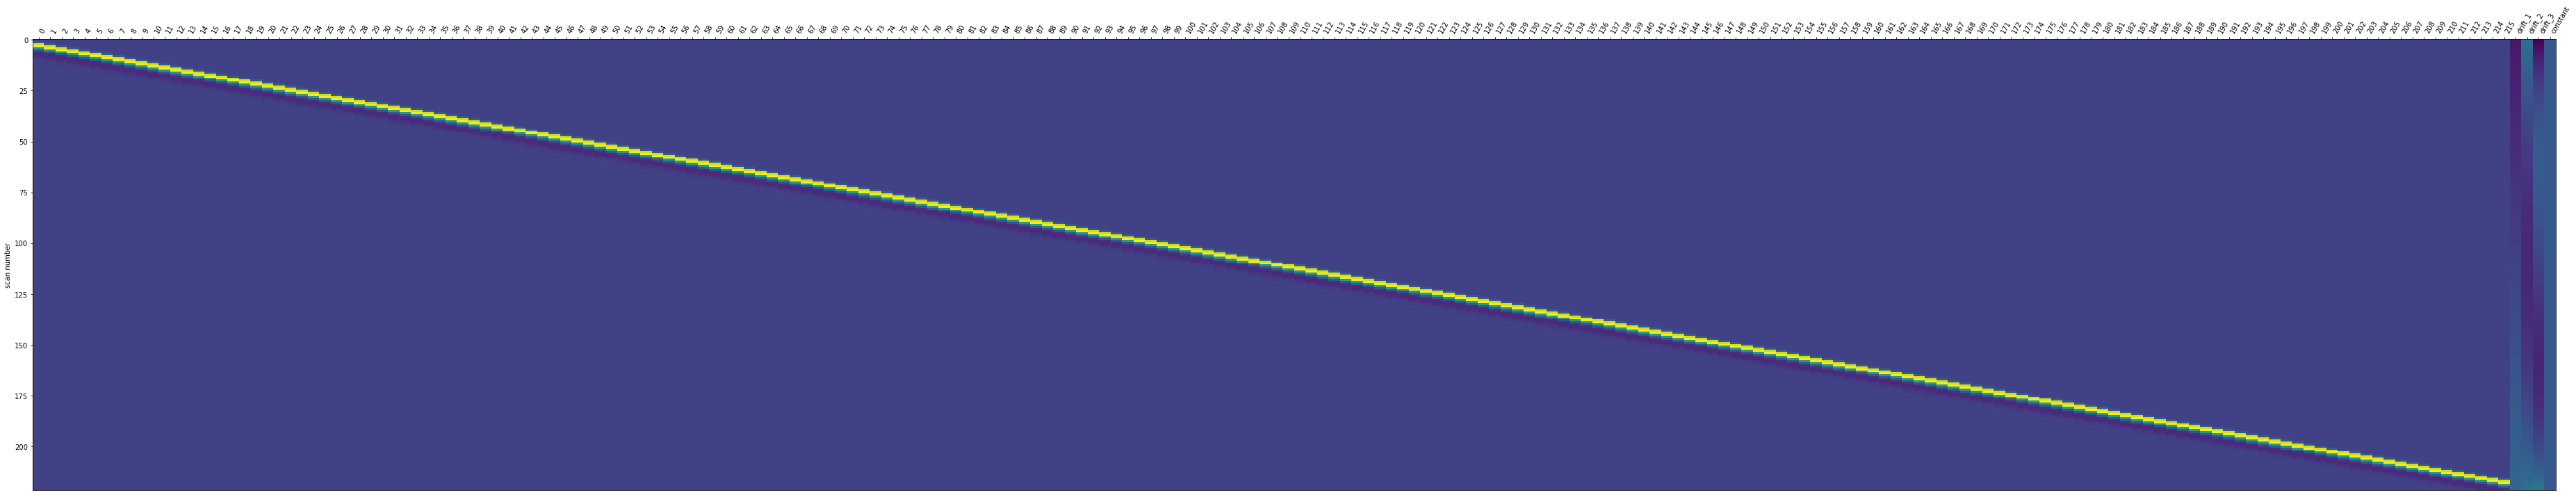

In [13]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

**Statistical analysis - 1st level**

In [72]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])


In [73]:
from nilearn.glm.first_level import FirstLevelModel

print('Fitting a GLM')
fmri_glm = FirstLevelModel()
fmri_glm.fit(func_data_preproc2standard, design_matrices=design_matrix)

Fitting a GLM


FirstLevelModel(signal_scaling=True)

In [74]:
z_maps=[]
for contrast in basic_contrasts:
    z_maps.append(fmri_glm.compute_contrast(basic_contrasts[contrast], output_type='z_score'))

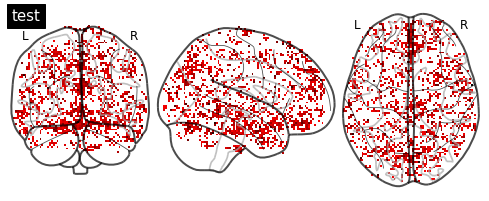

In [75]:
# plot the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_glass_brain(
    z_maps[10], threshold=3.0, title='test')
plotting.show()



In [76]:
len(z_maps)

220

# Decoding


/Users/home/.local/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



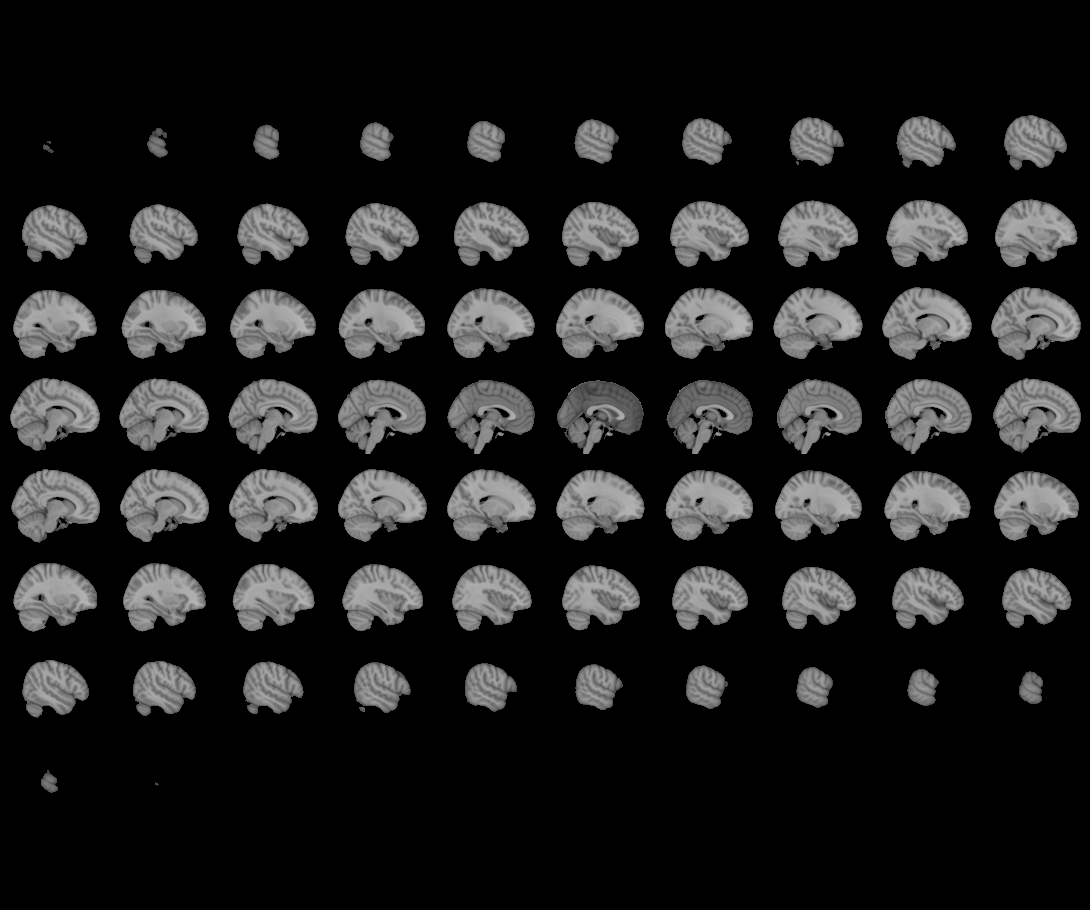
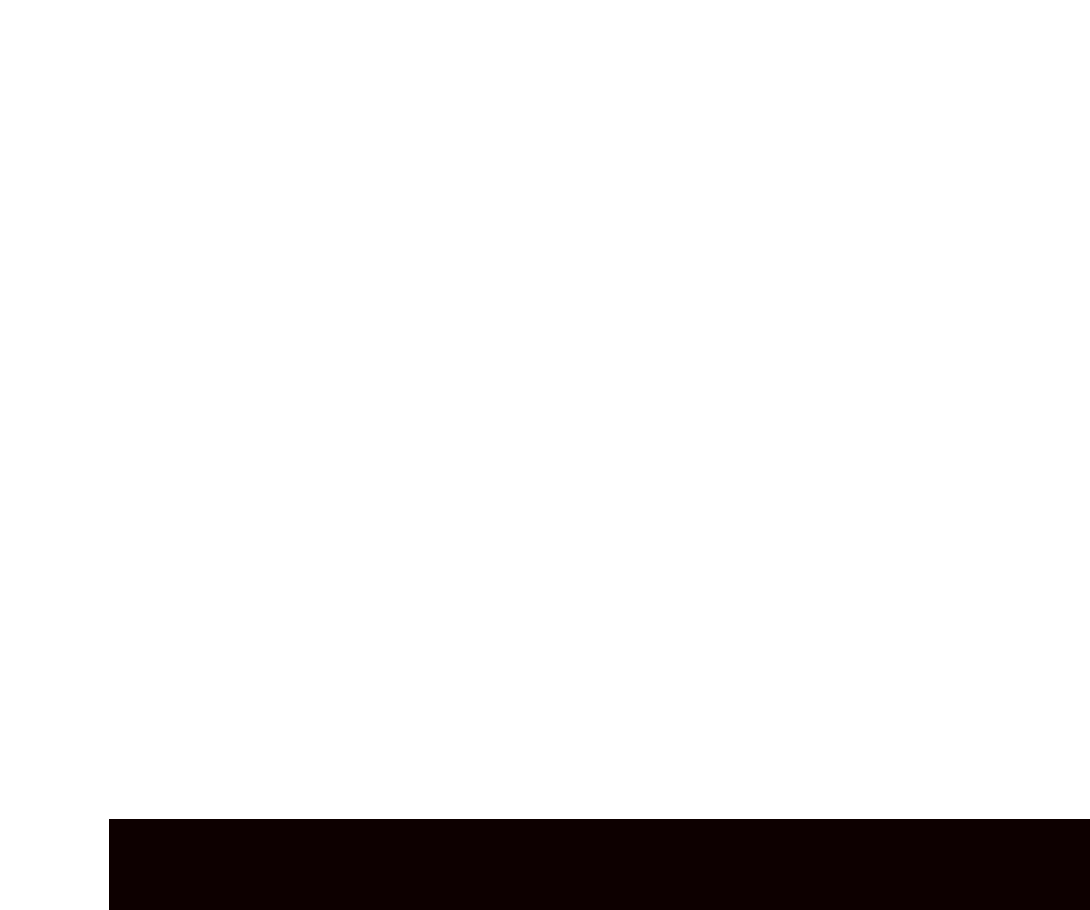

In [99]:
# brain_mask = datasets.load_mni152_brain_mask()

from nilearn.datasets import fetch_icbm152_brain_gm_mask
brain_mask = fetch_icbm152_brain_gm_mask()


dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_filename = dataset.maps

frontal_mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in [48, 49]])
plotting.view_img(frontal_mask)


In [100]:
from nilearn.decoding import Decoder 

decoder = Decoder(estimator='svc', mask=frontal_mask) 

/Users/home/.local/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:140: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(
/Users/home/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/home/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2794: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


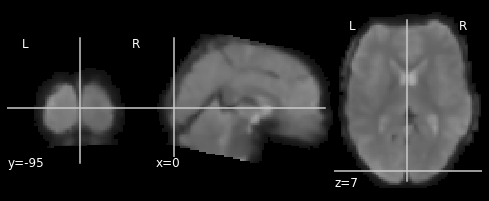

In [101]:
plotting.plot_roi(frontal_mask, bg_img=mean_fmri_img_2standard,
                  cmap='Paired')

In [102]:
# input are z_maps

# load events.tsv
events_PATH='/Users/home/Documents/GitHub/MVPA-speech_project/convert-bids-admin/DOCKER/events_epoch_fonologico.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head(10))

conditions=events_df['trial_type'][:216]


  trial_type  onset  duration
0  Baseline     0.0       2.5
1  Baseline     2.5       2.5
2  Baseline     5.0       2.5
3  Baseline     7.5       2.5
4  Baseline    10.0       2.5
5  Baseline    12.5       2.5
6      Task    15.0       2.5
7      Task    17.5       2.5
8      Task    20.0       2.5
9      Task    22.5       2.5


In [103]:
len(conditions)
print(conditions)

0      Baseline 
1      Baseline 
2      Baseline 
3      Baseline 
4      Baseline 
         ...    
211        Task 
212        Task 
213        Task 
214        Task 
215        Task 
Name: trial_type, Length: 216, dtype: object


In [104]:
from nilearn.image import index_img
trainset = index_img(z_maps, slice(0, -54))
trainset.shape

(91, 109, 91, 166)

In [105]:
decoder.fit(trainset, conditions[:-50]) 

/Users/home/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  13   52   65   96  100  115  116  132  152  171  199  200  398 2457
 2478 2516 2517 2518 2519 2520 2521 2522 2523 2524 2527 2528 2557 2576
 2597 2598 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645 2652
 2653 2667 2668 2669 2686 2687 2706 2707 2708 2709 2729 2730 2731 2732
 2753 2754 2755 2756 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781
 2788 2789 2790 2803 2804 2805 2806 2822 2823 2824 2842 2843 2844 2845
 2865 2866 2867 2888 2889 2890 2891 2892 2915 2916 2917 2935 2936 2937
 2938 2939 2946 2947 2948 2949 2961 2962 2978 2979 2997 2998 2999 3019
 3020 3042 3043 3044 3068 3069 3094 3095 3096 3114 3115 3126 3141 3142
 3160 3161 3181 3182 3183 3204 3205 3206 3230 3256 3257 3283 3284 3312
 3328 3347 3368 3369 3392 3393 3446 3474 3533 3555 3717 3740 3764 3898] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Us

In [106]:
print(decoder.cv_scores_) 

{'Baseline ': [0.8181818181818182, 0.9090909090909092, 0.9242424242424243, 0.8333333333333334, 0.8787878787878788, 0.9242424242424243, 0.85, 0.9000000000000001, 0.9272727272727272, 0.8181818181818181], 'Task ': [0.8181818181818182, 0.9090909090909092, 0.9242424242424243, 0.8333333333333334, 0.8787878787878788, 0.9242424242424243, 0.85, 0.9000000000000001, 0.9272727272727272, 0.8181818181818181]}


In [107]:
testset = index_img(z_maps, slice(-54,-4))
testset.shape

(91, 109, 91, 50)

In [108]:
prediction=decoder.predict(testset)

In [113]:
print((prediction == conditions[-50:]).sum() / float(len(conditions[-50:])))

0.76


/Users/home/.local/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



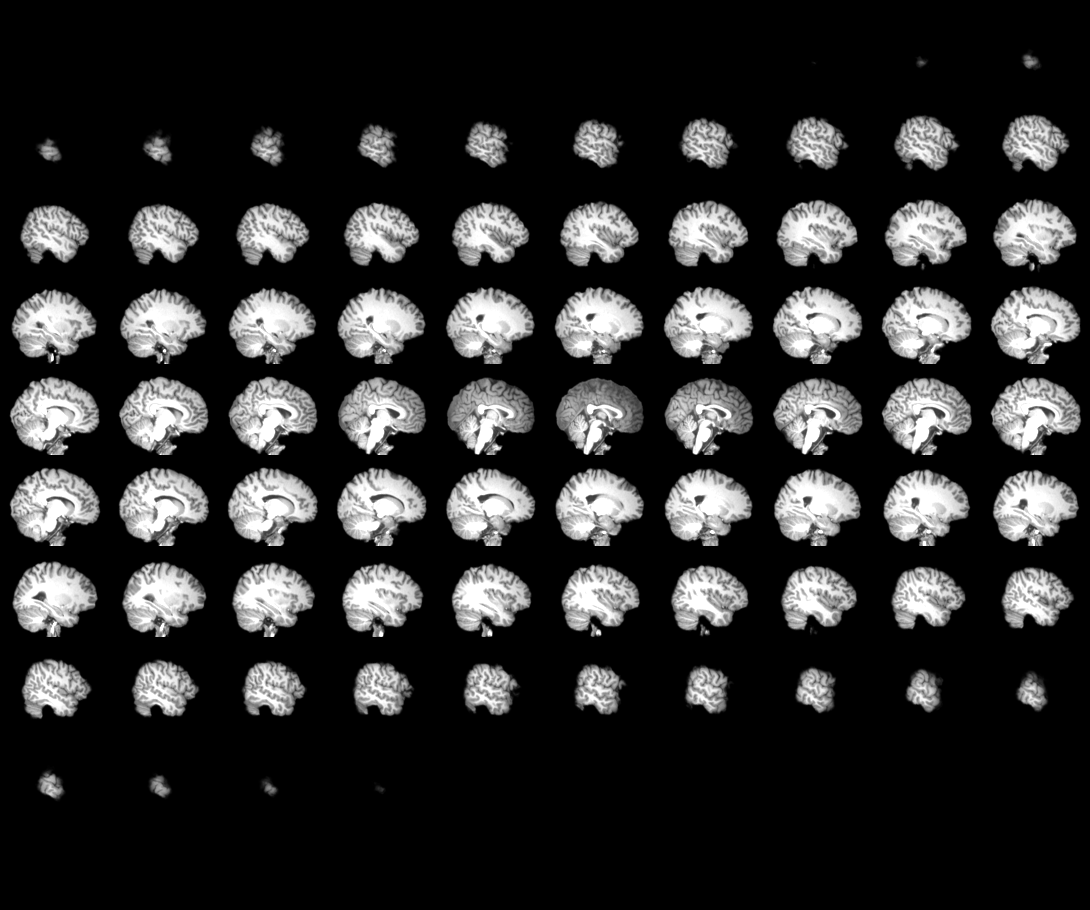
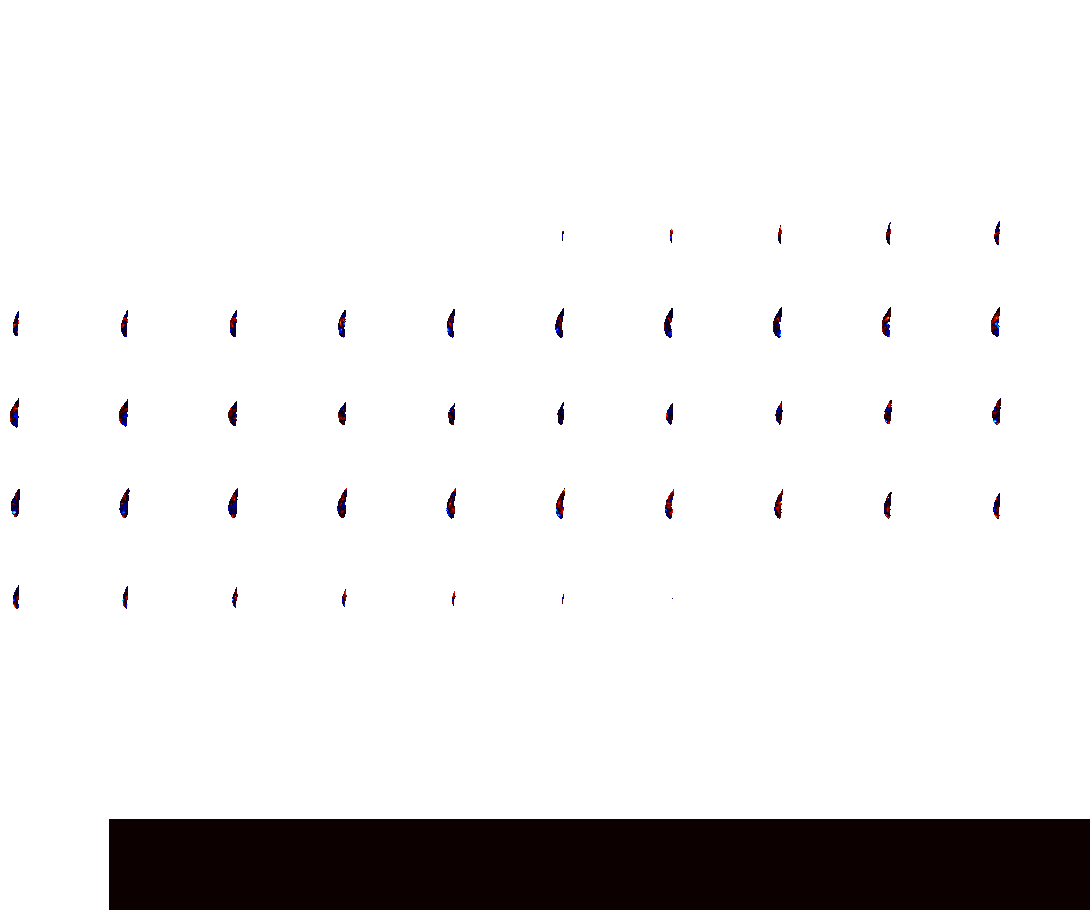

In [110]:
plotting.view_img(
    decoder.coef_img_['Task '], bg_img=t1w_prepro_file_path,
    title="SVM weights", dim=-1
)

# dummy decoder - como avaliar a qualidade de um classificador?

In [ ]:
dummy_decoder = Decoder(estimator='dummy_classifier', mask=brain_mask)

dummy_decoder.fit(trainset, conditions[:-50]) 

dummy_prediction=dummy_decoder.predict(trainset)


In [ ]:
dummy_decoder.dummy_output_

# Functional connectivity

In [ ]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

#yeo = datasets.fetch_atlas_yeo_2011()
#atlas_filename=yeo['thick_17']

In [ ]:
#yeo.description


In [ ]:
coordinates = plotting.find_parcellation_cut_coords(atlas_filename)
plotting.plot_roi(atlas_filename)

In [ ]:
coordinates


In [ ]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

In [ ]:
from nilearn.image import index_img

baseline_imgs = index_img(func_data_preproc2standard, baselineidxs)
task_imgs = index_img(func_data_preproc2standard, taskidxs)

In [ ]:
baseline_series = masker.fit_transform(baseline_imgs)
task_series = masker.fit_transform(task_imgs)

In [ ]:
print(baseline_series.shape)
print(task_series.shape)

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix_baseline = correlation_measure.fit_transform([baseline_series])[0]

correlation_matrix_task = correlation_measure.fit_transform([task_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix_baseline, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix_baseline, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix_task, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix_task, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

In [ ]:
plotting.plot_connectome(correlation_matrix_baseline, coordinates,
                         title='baseline corr',
                         edge_threshold="90%",edge_cmap="copper", colorbar="true")

plotting.plot_connectome(correlation_matrix_task, coordinates,
                         title='task corr',
                         edge_threshold="90%",edge_cmap="copper", colorbar="true")
